<a href="https://colab.research.google.com/github/MogY23/HSE_project_credit_scoring_23/blob/main/DS_for_nonDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подключение библиотек

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import psycopg2
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier, Pool


## Подключение к БД. Скачивание данных и сохранение их в формате csv

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-06-06 05:21:31--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-06-06 05:21:32 (438 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [4]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [78.0 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,056 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe am

In [5]:
conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

# получаем сырые данные

query = '''
SELECT * from public.credit_scoring
        '''


In [6]:
raw_data = pd.read_sql_query(query, con = conn)

<ipython-input-6-b29b82c53af5>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_data = pd.read_sql_query(query, con = conn)


In [7]:
raw_data.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b


In [ ]:
#Выгружаем данные в csv
raw_data.to_csv('raw_data_scoring.csv')

## EDA

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   135155 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
 10  RealEstateLoansOrLines                150000 non-null  object 
 11  

В датасете 150 000 наблюдений и 12 признаков. В 3 признаках присутствуют пропуски


In [9]:
raw_data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,135155.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.293618,0.421033,353.005076,6.670221e+03,8.452760,0.265973,0.240387,0.757222
std,0.249746,249.755371,14.772577,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,20.000000


* SeriousDlqin2yrs - не сбалансировано. Клиентов, имеющих просрочу меньше, 
чем тех, которые платили во время, как миниму, 75% клиентов не имели просрочки

* RevolvingUtilizationOfUnsecuredLines - балансы клиентов скошены вправо

* В данных возраста age есть некорректные значения максимальное 109 под вопросом минимальное в 0 точно ошибочно. При этом 75% клиентов не младше 41 лет

* У большинства клиентов нет иждевенцев и просрочек

In [10]:
raw_data.duplicated().sum()

634

Потенциально возможны дубликаты, но туда попадают только строки с пропусками. А в остальных значениях как раз много совпадений. Для большинства нет просрочек, иждивенцев

In [11]:
raw_data.query('age==age and MonthlyIncome==MonthlyIncome and NumberOfDependents==NumberOfDependents').duplicated().sum()

89

In [12]:
temp=raw_data.query('age==age and MonthlyIncome==MonthlyIncome and NumberOfDependents==NumberOfDependents').duplicated()


In [13]:
temp=pd.DataFrame(temp)


In [14]:
index_del=temp[temp[0]==True].index
data=raw_data.drop(index=index_del)

In [15]:
data.query('age==age and MonthlyIncome==MonthlyIncome and NumberOfDependents==NumberOfDependents').duplicated().sum()

0

In [16]:
data['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.933134
1    0.066866
Name: SeriousDlqin2yrs, dtype: float64

<Axes: >

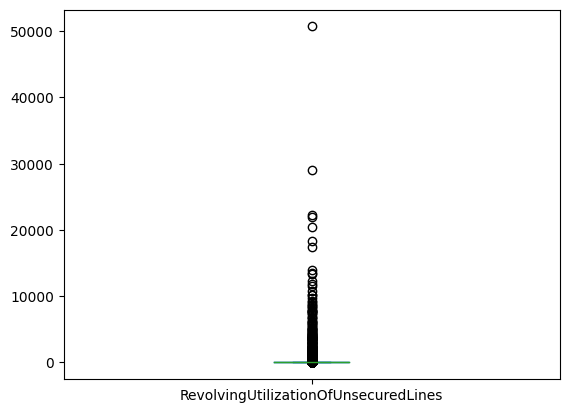

In [17]:
data['RevolvingUtilizationOfUnsecuredLines'].plot(kind='box')

In [18]:
#Посмотрим нулевые значения в трех разных полях у одних и тех же клиентов или нет
temp=data.query('age!=age and MonthlyIncome!=MonthlyIncome and NumberOfDependents!=NumberOfDependents').shape[0]
temp

376

In [19]:
#Пересечение небольшое
print(f'При удалении просто нулевых данных потеряем\
 {(data.age.isna().sum()+data.MonthlyIncome.isna().sum()+data.NumberOfDependents.isna().sum()-2*temp)/data.shape[0]:.1%}')

При удалении просто нулевых данных потеряем 31.9%


In [20]:
#Посмотрим распределение возраста, без нулевых значений
data.query('age!=0')['age'].describe()

count    135065.000000
mean         52.312420
std          14.757961
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [21]:
print(f'Количество клиентов с возрастом = 0 - {data.query("age==0").shape[0]}')

Количество клиентов с возрастом = 0 - 1


У нас есть возрастная группа попробуем по ней восстановить возраст. Посомтрим сколько таких групп

In [22]:
data['GroupAge'].value_counts(normalize=True)

d    0.315300
e    0.286357
c    0.283215
b    0.115122
a    0.000007
Name: GroupAge, dtype: float64

In [23]:
#Посмотрим минимальное и максимальное значение в каждой группе
data.pivot_table(index='GroupAge',values='age',aggfunc=['min','max'])

,min,max
,age,age
GroupAge,,
a,0.0,0.0
b,21.0,34.0
c,35.0,49.0
d,50.0,64.0
e,65.0,109.0


In [24]:
data.query("age==0")['SeriousDlqin2yrs']

41655    0
Name: SeriousDlqin2yrs, dtype: int64

В будущем можно будет удалить данные с 0 возрастом

In [25]:
#Посмотрим какие группы в пропусках указаны
data.query('age!=age')['GroupAge'].value_counts(normalize=True)

e    1.0
Name: GroupAge, dtype: float64

In [26]:
data.query('age!=age')['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.932637
1    0.067363
Name: SeriousDlqin2yrs, dtype: float64

данные со значением целевой переменной распределены также,как и во всем датасете. В идеале проверить и по другим переменным. Но в общем, выглядит так, что можно удалить было бы значения, но попробуем восстановить

<Axes: >

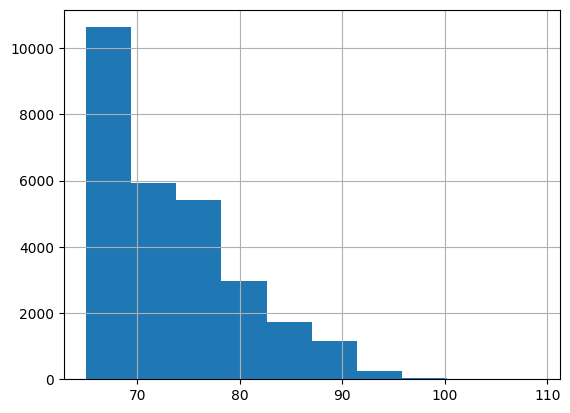

In [27]:
data.query('GroupAge=="e"')['age'].hist()

In [28]:
#Действуем из предположения, что возрастную группу заполняли нормально, а не ставили всем с пропусками группу e. 
#Можно было бы поисследовать, но некогда)
#Заполним медианным значением, так как медина устойчивее к выбросам
data['age']=data['age'].fillna(data.query('GroupAge=="e"')['age'].median())

In [29]:
data['GroupAge'].value_counts(normalize=True)

d    0.315300
e    0.286357
c    0.283215
b    0.115122
a    0.000007
Name: GroupAge, dtype: float64

In [30]:
data=data.drop(index=data.query("age==0").index)

Попробуем понять можем ли мы восстановить пропуски в месячном доходе

In [31]:
data.query('MonthlyIncome!=MonthlyIncome')['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.943863
1    0.056137
Name: SeriousDlqin2yrs, dtype: float64

In [32]:
data.query('MonthlyIncome!=MonthlyIncome')['GroupAge'].value_counts(normalize=True)

e    0.370018
d    0.330329
c    0.214490
b    0.085164
Name: GroupAge, dtype: float64

In [33]:
data['NumberOfOpenCreditLinesAndLoans'].describe()

count    149910.000000
mean          8.457008
std           5.144529
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [34]:
data.query('MonthlyIncome!=MonthlyIncome')['NumberOfOpenCreditLinesAndLoans'].describe()

count    29731.000000
mean         7.216071
std          4.842720
min          0.000000
25%          4.000000
50%          6.000000
75%         10.000000
max         45.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [35]:
cm=data.corr()
cm.style.background_gradient(cmap='coolwarm')

<ipython-input-35-0d734a94b1c3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm=data.corr()


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001804,-0.101671,0.125776,-0.007622,-0.019805,-0.029822,0.117320,0.102331,0.045988
RevolvingUtilizationOfUnsecuredLines,-0.001804,1.000000,-0.002777,-0.001312,0.003959,0.007118,-0.011305,-0.001058,-0.001045,0.001549
age,-0.101671,-0.002777,1.000000,-0.054495,0.019505,0.030104,0.129399,-0.052462,-0.049026,-0.188112
NumberOfTime30-59DaysPastDueNotWorse,0.125776,-0.001312,-0.054495,1.000000,-0.006506,-0.010025,-0.054956,0.983423,0.986863,-0.002397
DebtRatio,-0.007622,0.003959,0.019505,-0.006506,1.000000,-0.028733,0.049451,-0.008290,-0.007499,-0.040749
MonthlyIncome,-0.019805,0.007118,0.030104,-0.010025,-0.028733,1.000000,0.091090,-0.012559,-0.010914,0.062438
NumberOfOpenCreditLinesAndLoans,-0.029822,-0.011305,0.129399,-0.054956,0.049451,0.091090,1.000000,-0.079747,-0.070783,0.064795
NumberOfTimes90DaysLate,0.117320,-0.001058,-0.052462,0.983423,-0.008290,-0.012559,-0.079747,1.000000,0.992716,-0.009920
NumberOfTime60-89DaysPastDueNotWorse,0.102331,-0.001045,-0.049026,0.986863,-0.007499,-0.010914,-0.070783,0.992716,1.000000,-0.010668
NumberOfDependents,0.045988,0.001549,-0.188112,-0.002397,-0.040749,0.062438,0.064795,-0.009920,-0.010668,1.000000


Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней и сколько раз наблюдалась просрочка (90 и более дней) и Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней.. сильно скоррелированны, что ожидаемо


In [36]:
temp=data.query('age!=age and MonthlyIncome!=MonthlyIncome and NumberOfDependents!=NumberOfDependents').shape[0]
temp
print(f'При удалении просто нулевых данных потеряем\
 {(data.age.isna().sum()+data.MonthlyIncome.isna().sum()+data.NumberOfDependents.isna().sum()-2*temp)/data.shape[0]:.1%}')

При удалении просто нулевых данных потеряем 22.5%


In [37]:
(data['MonthlyIncome']/1000).describe()

count    120179.000000
mean          6.674625
std          14.389141
min           0.000000
25%           3.400000
50%           5.400000
75%           8.250000
max        3008.750000
Name: MonthlyIncome, dtype: float64

In [38]:
(data.query('SeriousDlqin2yrs==1')['MonthlyIncome']/1000).describe()

count    8355.000000
mean        5.632055
std         6.171943
min         0.000000
25%         2.967500
50%         4.500000
75%         6.801000
max       250.000000
Name: MonthlyIncome, dtype: float64

In [39]:
(data.query('SeriousDlqin2yrs==0')['MonthlyIncome']/1000).describe()

count    111824.000000
mean          6.752521
std          14.818370
min           0.000000
25%           3.470000
50%           5.474000
75%           8.333000
max        3008.750000
Name: MonthlyIncome, dtype: float64

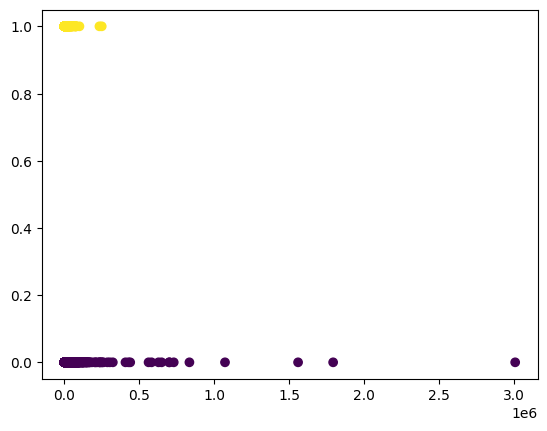

In [40]:
plt.scatter(data['MonthlyIncome'], data['SeriousDlqin2yrs'], c=data['SeriousDlqin2yrs'])

Среди тех, кто просрочил кредит более, чем на 90 дней ежемесячный доход ниже

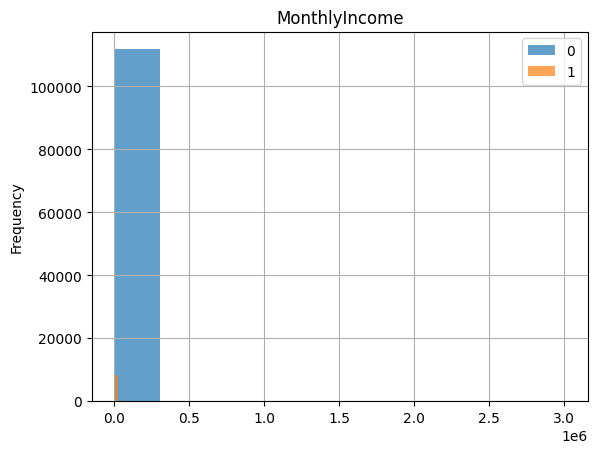

In [41]:
leg=[]
for i,g in enumerate(data.SeriousDlqin2yrs.unique()):
  data.query('SeriousDlqin2yrs==@g')['MonthlyIncome'].plot(kind='hist',title='MonthlyIncome',grid=True,alpha=0.7,sharex=True)
  leg.append(g)
plt.legend(leg)
plt.show()

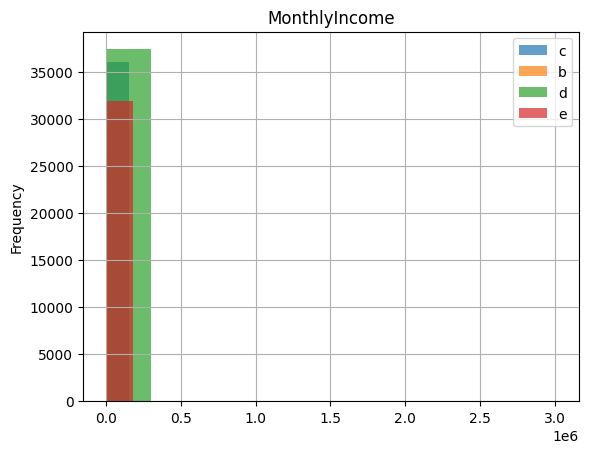

In [42]:
gr=[]
for i,g in enumerate(data.GroupAge.unique()):
  data.query('GroupAge==@g')['MonthlyIncome'].plot(kind='hist',title='MonthlyIncome',grid=True,alpha=0.7,sharex=True)
  gr.append(g)
plt.legend(gr)
plt.show()


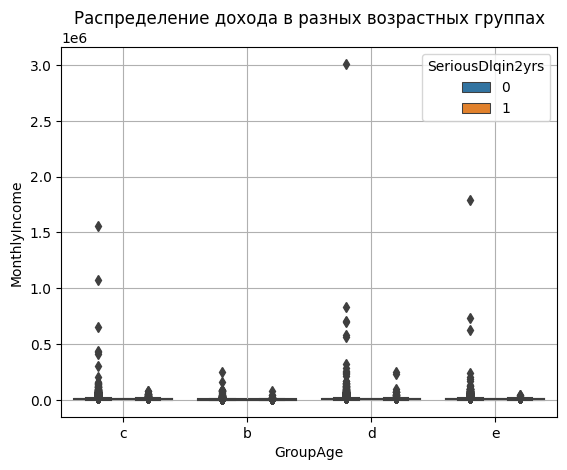

<Figure size 1000x1500 with 0 Axes>

In [43]:
ax = sns.boxplot(y='MonthlyIncome', x='GroupAge',hue='SeriousDlqin2yrs', data=data) 
name=f'Распределение дохода в разных возрастных группах'
plt.title(name)
plt.grid(True)
plt.figure(figsize=(10,15))

plt.show()

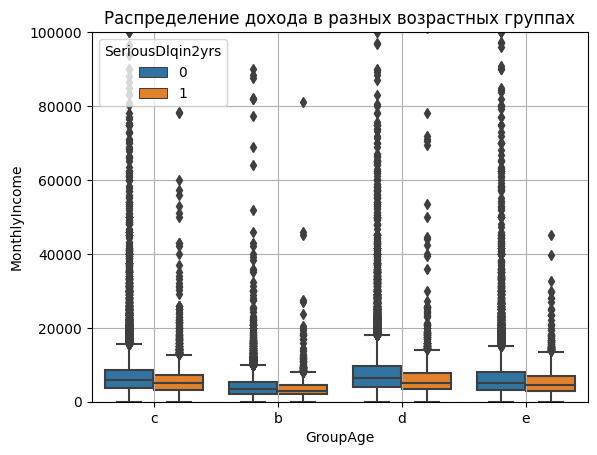

<Figure size 1000x1500 with 0 Axes>

In [44]:

ax = sns.boxplot(y='MonthlyIncome', x='GroupAge',hue='SeriousDlqin2yrs', data=data) 
name=f'Распределение дохода в разных возрастных группах'
plt.title(name)
plt.grid(True)
plt.figure(figsize=(10,15))
ax.set_ylim([0, 100000])
plt.show()

Видим, что доход  d, например,выше дохода гурппы b. Данные по доходы во всех группах имеют выбросы. Пропуски будем заполнять медианой, орииентируясь на возраст и просроку у клиента

In [45]:
def income_fill (row):
  group=row['GroupAge']
  SeriousDlqin2yrs=row['SeriousDlqin2yrs']
  MI=row['MonthlyIncome']
  if MI!=MI:
    return data.query('SeriousDlqin2yrs==@SeriousDlqin2yrs and GroupAge==@group')['MonthlyIncome'].median(skipna=True)
  else:
     return MI


In [46]:
data['MonthlyIncome']=data.apply(income_fill,axis=1)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149910 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149910 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149910 non-null  float64
 2   age                                   149910 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  149910 non-null  int64  
 4   DebtRatio                             149910 non-null  float64
 5   MonthlyIncome                         149910 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149910 non-null  int64  
 7   NumberOfTimes90DaysLate               149910 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  149910 non-null  int64  
 9   NumberOfDependents                    145986 non-null  float64
 10  RealEstateLoansOrLines                149910 non-null  object 
 11  

In [48]:
(data['MonthlyIncome']/1000).describe()

count    149910.000000
mean          6.437611
std          12.897685
min           0.000000
25%           3.734000
50%           5.416000
75%           7.400000
max        3008.750000
Name: MonthlyIncome, dtype: float64

In [49]:
temp=data.query('age!=age and MonthlyIncome!=MonthlyIncome and NumberOfDependents!=NumberOfDependents').shape[0]
temp
print(f'При удалении просто нулевых данных потеряем\
 {(data.age.isna().sum()+data.MonthlyIncome.isna().sum()+data.NumberOfDependents.isna().sum()-2*temp)/data.shape[0]:.1%}')

При удалении просто нулевых данных потеряем 2.6%


In [50]:
data=data.dropna(subset=['NumberOfDependents'])

In [51]:
data.duplicated().sum()

454

In [52]:
data=data.drop_duplicates()
data.duplicated().sum()

0

## Обучение модели

In [53]:
data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents',
       'RealEstateLoansOrLines', 'GroupAge'],
      dtype='object')

так как у нас сильно скореллированы значения 'NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate',
       'NumberOfTime60-89DaysPastDueNotWorse' оставим только один признак
разделим признаки на категориальные и числовые, выделем целевую переменную

In [54]:
categorical = ['RealEstateLoansOrLines','GroupAge']
numeric_features = ['RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfDependents']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
y=data['SeriousDlqin2yrs']
X=data.drop(['SeriousDlqin2yrs','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse'],axis=1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['SeriousDlqin2yrs'],test_size=0.25, random_state=255)

In [68]:
X_train_tr= column_transformer.fit_transform(X_train)
X_test_tr = column_transformer.transform(X_test)

In [87]:
column_transformer.get_feature_names_out()

array(['ohe__RealEstateLoansOrLines_A', 'ohe__RealEstateLoansOrLines_B',
       'ohe__RealEstateLoansOrLines_C', 'ohe__RealEstateLoansOrLines_D',
       'ohe__RealEstateLoansOrLines_E', 'ohe__GroupAge_b',
       'ohe__GroupAge_c', 'ohe__GroupAge_d', 'ohe__GroupAge_e',
       'scaling__RevolvingUtilizationOfUnsecuredLines', 'scaling__age',
       'scaling__NumberOfTime30-59DaysPastDueNotWorse',
       'scaling__DebtRatio', 'scaling__MonthlyIncome',
       'scaling__NumberOfOpenCreditLinesAndLoans',
       'scaling__NumberOfDependents'], dtype=object)

In [56]:
y_train.value_counts(normalize=True)

0    0.932459
1    0.067541
Name: SeriousDlqin2yrs, dtype: float64

In [57]:
y_test.value_counts(normalize=True)

0    0.932441
1    0.067559
Name: SeriousDlqin2yrs, dtype: float64

In [58]:
y.value_counts(normalize=True)

0    0.932455
1    0.067545
Name: SeriousDlqin2yrs, dtype: float64

In [59]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145532 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  145532 non-null  float64
 1   age                                   145532 non-null  float64
 2   NumberOfTime30-59DaysPastDueNotWorse  145532 non-null  int64  
 3   DebtRatio                             145532 non-null  float64
 4   MonthlyIncome                         145532 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       145532 non-null  int64  
 6   NumberOfDependents                    145532 non-null  float64
 7   RealEstateLoansOrLines                145532 non-null  object 
 8   GroupAge                              145532 non-null  object 
dtypes: float64(5), int64(2), object(2)
memory usage: 11.1+ MB


In [67]:
#Здесь приводим данные к единому масштабу
X_train_new, X_test_new, y_train_st, y_test_st = train_test_split(X.drop(categorical,axis=1), y, stratify=data['SeriousDlqin2yrs'],test_size=0.25, random_state=255)


scaler = StandardScaler()
scaler.fit(X_train_new)


X_train_st = scaler.transform(X_train_new)
X_test_st = scaler.transform(X_test_new)

###  Логистическая регрессия

In [64]:
model = LogisticRegression()
model.fit(X_train_tr, y_train)
predictions_base = model.predict(X_test_tr) #пропускаем тестовые данные и сохраням предсказания целевой переменной
probabilities= model.predict_proba(X_test_tr)[:,1] #сохраняем вероятности отнесесния к классу 1



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [74]:
model_st = LogisticRegression()
model_st.fit(X_train_st, y_train_st)
predictions_base_st = model_st.predict(X_test_st) #пропускаем тестовые данные и сохраням предсказания целевой переменной
probabilities_st= model_st.predict_proba(X_test_st)[:,1] #сохраняем вероятности отнесесния к классу 1

In [75]:
print('ROC_AUC (с категориальными): {:.2f}'.format(roc_auc_score(y_test, probabilities)))
print('ROC_AUC (без категориальных): {:.2f}'.format(roc_auc_score(y_test_st, probabilities_st)))

ROC_AUC (с категориальными): 0.67
ROC_AUC (без категориальных): 0.66


невысокий ROC_AUC для несбалансированных классов, скорее всего говорит о том, что сложно подобрать порог так, чтоб сильно повлиять на качество моделии

**С КАТЕГОРИАЛЬНЫМИ ПРИЗНАКАМИ**

In [76]:
threshold = 0.5# здесь можно поиграться с порогом

predictions = [1 if i>= threshold else 0 for i in probabilities]

In [77]:
#Тут выводим основыне метрики
print('Accuracy (Доля правильных ответов): {:.2f}'.format(accuracy_score(y_test,predictions)))
print('Precision (Доля правильных ответов только среди целевого класса ): {:.2f}'.format(precision_score(y_test,predictions)))
print('Recall (сколько реальных объектов "1" класса  обнаружено): {:.2f}'.format(recall_score(y_test,predictions)))
print('F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): {:.2f}'.format(f1_score(y_test,predictions)))

Accuracy (Доля правильных ответов): 0.93
Precision (Доля правильных ответов только среди целевого класса ): 0.62
Recall (сколько реальных объектов "1" класса  обнаружено): 0.01
F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): 0.02


In [78]:
for i in range(2,9):
  threshold = i/10# здесь можно поиграться с порогом
  predictions = [1 if i>= threshold else 0 for i in probabilities]
  print(f'THRESHOLD = {threshold}')
  print('Accuracy (Доля правильных ответов): {:.2f}'.format(accuracy_score(y_test,predictions)))
  print('Precision (Доля правильных ответов только среди целевого класса ): {:.2f}'.format(precision_score(y_test,predictions)))
  print('Recall (сколько реальных объектов "1" класса  обнаружено): {:.2f}'.format(recall_score(y_test,predictions)))
  print('F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): {:.2f}'.format(f1_score(y_test,predictions)))
  print('_____________________')

THRESHOLD = 0.2
Accuracy (Доля правильных ответов): 0.93
Precision (Доля правильных ответов только среди целевого класса ): 0.35
Recall (сколько реальных объектов "1" класса  обнаружено): 0.02
F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): 0.04
_____________________
THRESHOLD = 0.3
Accuracy (Доля правильных ответов): 0.93
Precision (Доля правильных ответов только среди целевого класса ): 0.57
Recall (сколько реальных объектов "1" класса  обнаружено): 0.01
F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): 0.03
_____________________
THRESHOLD = 0.4
Accuracy (Доля правильных ответов): 0.93
Precision (Доля правильных ответов только среди целевого класса ): 0.62
Recall (сколько реальных объектов "1" класса  обнаружено): 0.01
F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): 0.02
_____________________
THRESHOLD = 0.5
Accuracy (Доля пра

**БЕЗ КАТЕГОРИАЛЬНЫХ**

In [80]:
threshold = 0.5# здесь можно поиграться с порогом

predictions_st = [1 if i>= threshold else 0 for i in probabilities_st]

In [81]:
#Тут выводим основыне метрики
print('Accuracy (Доля правильных ответов): {:.2f}'.format(accuracy_score(y_test_st,predictions_st)))
print('Precision (Доля правильных ответов только среди целевого класса ): {:.2f}'.format(precision_score(y_test_st,predictions_st)))
print('Recall (сколько реальных объектов "1" класса  обнаружено): {:.2f}'.format(recall_score(y_test_st,predictions_st)))
print('F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): {:.2f}'.format(f1_score(y_test_st,predictions_st)))

Accuracy (Доля правильных ответов): 0.93
Precision (Доля правильных ответов только среди целевого класса ): 0.62
Recall (сколько реальных объектов "1" класса  обнаружено): 0.01
F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): 0.02


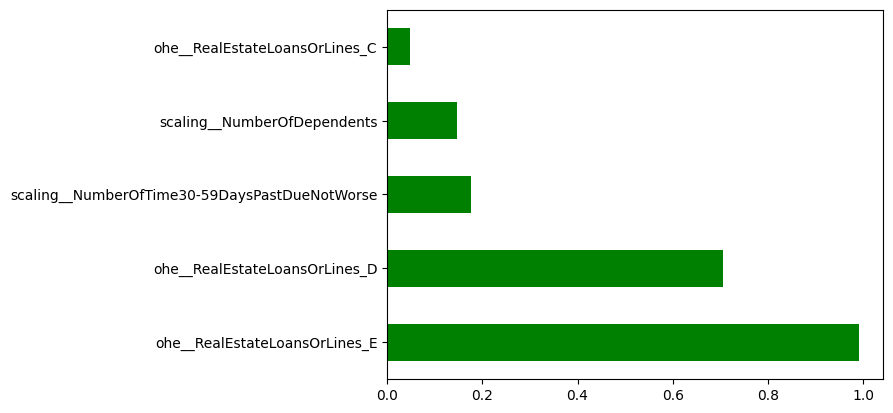

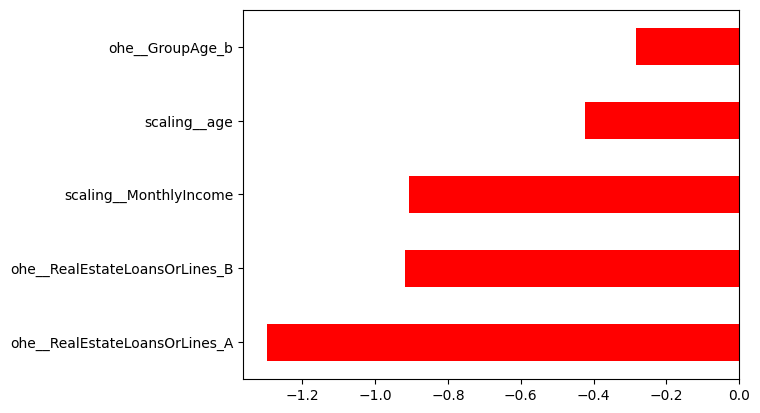

In [88]:
pd.Series(model.coef_[0], index=column_transformer.get_feature_names_out()).nlargest(5).plot(kind='barh',color='green')
plt.show()
pd.Series(model.coef_[0], index=column_transformer.get_feature_names_out()).nsmallest(5).plot(kind='barh',color='red')
plt.show()

In [91]:
coef_table = pd.DataFrame({'features' : list(column_transformer.get_feature_names_out()), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
0,ohe__RealEstateLoansOrLines_A,-1.297129
1,ohe__RealEstateLoansOrLines_B,-0.918438
13,scaling__MonthlyIncome,-0.905988
10,scaling__age,-0.423133
5,ohe__GroupAge_b,-0.284604
6,ohe__GroupAge_c,-0.116451
12,scaling__DebtRatio,-0.091647
7,ohe__GroupAge_d,-0.066018
14,scaling__NumberOfOpenCreditLinesAndLoans,-0.036332
9,scaling__RevolvingUtilizationOfUnsecuredLines,-0.002482


### Градиентный бустинг

In [92]:
train_set = Pool(X_train_tr, y_train)
test_set = Pool(X_test_tr, y_test)

In [93]:
gbm = CatBoostClassifier(iterations=700,
                          depth=3,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)

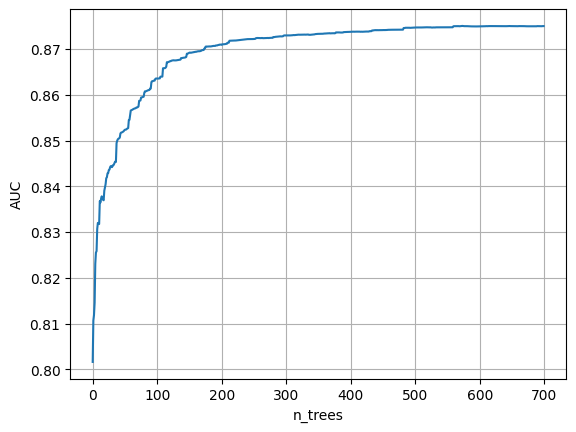

In [94]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [95]:
gbm = CatBoostClassifier(iterations=550,
                          depth=3,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)

In [96]:
print("auc-roc: ", roc_auc_score(y_test, gbm_preds[:, 1]))

auc-roc:  0.8747373741795098


In [97]:
for i in range(1,9):
  threshold = i/10# здесь можно поиграться с порогом
  predictions = [1 if i>= threshold else 0 for i in gbm_preds[:, 1]]
  print(f'THRESHOLD = {threshold}')
  print('Accuracy (Доля правильных ответов): {:.2f}'.format(accuracy_score(y_test,predictions)))
  print('Precision (Доля правильных ответов только среди целевого класса ): {:.2f}'.format(precision_score(y_test,predictions)))
  print('Recall (сколько реальных объектов "1" класса  обнаружено): {:.2f}'.format(recall_score(y_test,predictions)))
  print('F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): {:.2f}'.format(f1_score(y_test,predictions)))
  print('_____________________')


THRESHOLD = 0.1
Accuracy (Доля правильных ответов): 0.85
Precision (Доля правильных ответов только среди целевого класса ): 0.27
Recall (сколько реальных объектов "1" класса  обнаружено): 0.71
F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): 0.39
_____________________
THRESHOLD = 0.2
Accuracy (Доля правильных ответов): 0.92
Precision (Доля правильных ответов только среди целевого класса ): 0.42
Recall (сколько реальных объектов "1" класса  обнаружено): 0.51
F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): 0.46
_____________________
THRESHOLD = 0.3
Accuracy (Доля правильных ответов): 0.94
Precision (Доля правильных ответов только среди целевого класса ): 0.55
Recall (сколько реальных объектов "1" класса  обнаружено): 0.37
F1 (метрика Precision и Recall как бы направлены на избежание противоположных рисков,это их баланс ): 0.45
_____________________
THRESHOLD = 0.4
Accuracy (Доля пра

## Интепретация результатов

In [98]:
coef_table = pd.DataFrame({'features' : list(column_transformer.get_feature_names_out()), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

,features,importances
1,ohe__RealEstateLoansOrLines_B,0.004289
4,ohe__RealEstateLoansOrLines_E,0.005521
6,ohe__GroupAge_c,0.014786
3,ohe__RealEstateLoansOrLines_D,0.032428
7,ohe__GroupAge_d,0.105409
2,ohe__RealEstateLoansOrLines_C,0.119802
0,ohe__RealEstateLoansOrLines_A,0.188486
15,scaling__NumberOfDependents,0.292047
5,ohe__GroupAge_b,0.711962
14,scaling__NumberOfOpenCreditLinesAndLoans,0.937478


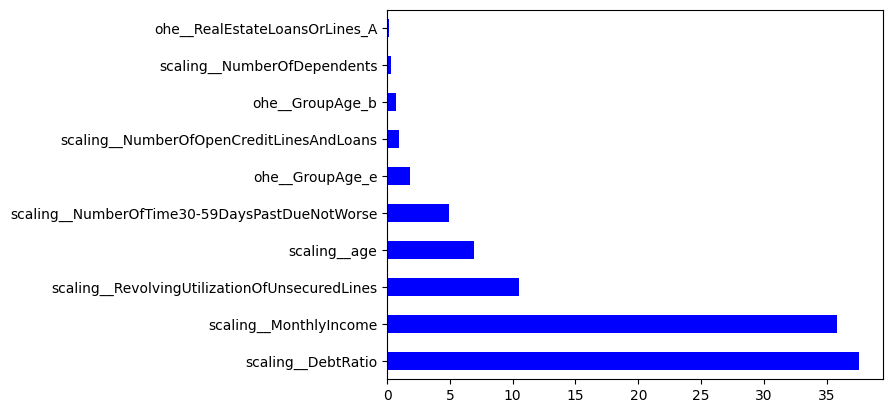

In [99]:
pd.Series(gbm.feature_importances_, index=column_transformer.get_feature_names_out()).nlargest(10).plot(kind='barh',color='blue')
plt.show()

In [100]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 8.5 MB/s eta 0:00:00


In [101]:
import shap
shap.initjs()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


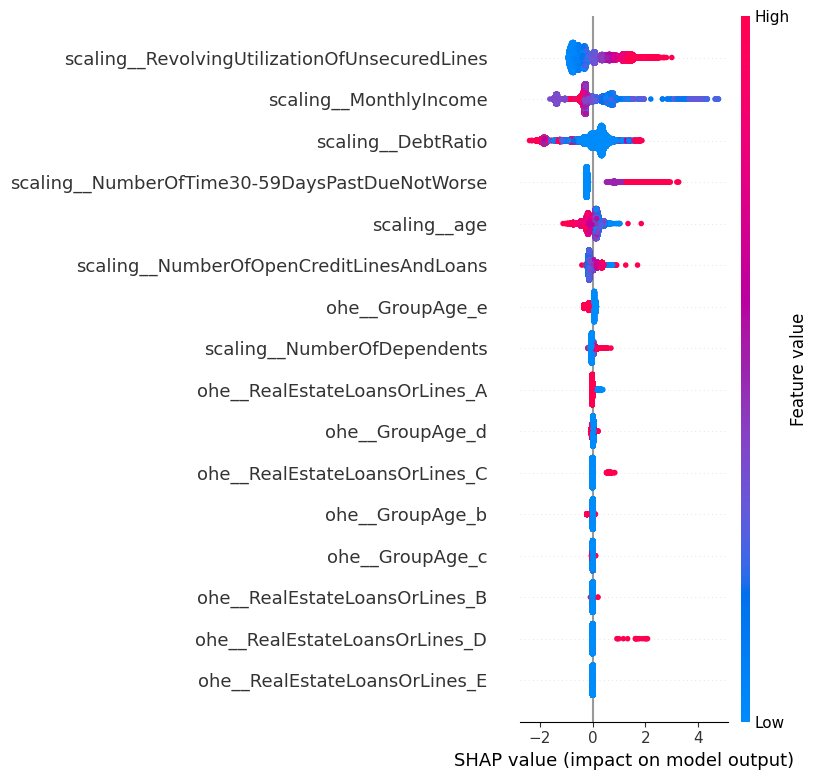

In [104]:
explainer = shap.TreeExplainer(gbm)
X_tt=pd.DataFrame(columns= column_transformer.get_feature_names_out(),data=X_test_tr)
shap_values = explainer.shap_values(X_tt)

shap.summary_plot(shap_values, X_tt)

In [ ]:
y.va